In [1]:
%matplotlib inline
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
if olfaction_prediction_path not in sys.path:
    sys.path.append(olfaction_prediction_path)
import opc_python
import numpy as np
from datetime import datetime
from copy import copy,deepcopy
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import pystan
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_curve,auc
from opc_python.utils import loading, scoring
from opc_python.gerkin import dream,fit1,fit2,params

In [2]:
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')

In [5]:
y,_ = dream.make_Y_obs('training',target_dilution='high',imputer='mask')
#values = y['mean_std'][:,:21]
#values.shape
values = np.dstack([y['subject'][i] for i in range(1,50)])
values = np.ma.array(values,mask=np.isnan(values))/100
values.data[values.mask]=0

The Y['mean_std'] matrix now has shape (338x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (338x21) molecules by perceptual descriptors, one for each subject


/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/numpy/ma/core.py:809: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


In [79]:
code = """
    data {
        int<lower=0,upper=1000> n_mol; // number of molecules
        int<lower=0,upper=100> n_desc; // number of descriptors
        int<lower=0,upper=100> n_sub; // number of subjects
        real<lower=0,upper=1> values[n_mol,n_desc,n_sub]; // data and replicates
        int<lower=0,upper=1> mask[n_mol,n_desc,n_sub]; // data and replicates
        }
    
    parameters {
        vector<lower=0.01,upper=0.49>[n_desc] mu1[n_sub]; // Strength of each molecule in each descriptor.  
        vector<lower=0.51,upper=0.99>[n_desc] mu2[n_sub]; // Strength of each molecule in each descriptor.  
        vector<lower=0,upper=100>[n_desc] n1[n_sub]; // Strength of each molecule in each descriptor.  
        vector<lower=0,upper=100>[n_desc] n2[n_sub]; // Strength of each molecule in each descriptor.  
        simplex[5] state[n_sub,n_desc]; // Strength of each molecule in each descriptor.  
        vector<lower=0,upper=1>[n_desc] dip[n_sub];
        }
        
    transformed parameters {
        vector<lower=0>[n_desc] a1[n_sub]; // Strength of each molecule in each descriptor.  
        vector<lower=0>[n_desc] a2[n_sub]; // Strength of each molecule in each descriptor.  
        vector<lower=0>[n_desc] b1[n_sub]; // Strength of each molecule in each descriptor.  
        vector<lower=0>[n_desc] b2[n_sub]; // Strength of each molecule in each descriptor. 
        
        for(k in 1:n_sub) {
            a1[k] <- mu1[k].*n1[k];
            a2[k] <- mu2[k].*n2[k];
            b1[k] <- (1-mu1[k]).*n1[k];
            b2[k] <- (1-mu2[k]).*n2[k];
        }
    }
        
    model {
        real x;
        real p50;
        real lp;
            
        for(k in 1:n_sub) {
            //a1[k] ~ lognormal(0,1);
            //b1[k] ~ lognormal(1,1);
            //a2[k] ~ lognormal(1,1);
            //b2[k] ~ lognormal(0,1);
            for(j in 1:n_desc) {
                state[k][j][3] ~ beta(1,1000);
                //dip[k][j] ~ lognormal(0,1);
                }
        }
        
        for (i in 1:n_mol) {
            for(j in 1:n_desc) {
                for(k in 1:n_sub) {
                    if(!mask[i][j][k]) {
                        x <- values[i][j][k];
                        if(x==0) {
                            lp <- log(
                                    state[k][j][1] + 
                                    //exp(log(state[k][j][2]) + beta_log(0,a1[k][j],b1[k][j])) +
                                    exp(log(state[k][j][3]) + uniform_log(0,0,1))
                                    );
                        }
                        else if(x==1) {
                            lp <- log(
                                    state[k][j][5] + 
                                    //exp(log(state[k][j][4]) + beta_log(1,a2[k][j],b2[k][j])) +
                                    exp(log(state[k][j][3]) + uniform_log(1,0,1))
                                    );
                        }
                        else { 
                            lp <- log(
                                    exp(log(state[k][j][2]) + beta_log(x,a1[k][j],b1[k][j])) +
                                    exp(log(state[k][j][3]) + uniform_log(x,0,1)) +
                                    exp(log(state[k][j][4]) + beta_log(x,a2[k][j],b2[k][j]))
                                    );
                        }
                        p50 <- exp(log(state[k][j][2]) + beta_log(0.5,a1[k][j],b1[k][j])) +
                               exp(log(state[k][j][3]) + uniform_log(0.5,0,1)) +
                               exp(log(state[k][j][4]) + beta_log(0.5,a2[k][j],b2[k][j]));
                               
                        if(x>0.495 && x<0.505) {
                                //lp <- log(exp(lp) - dip[k][j]*p50);
                            }
                        else {
                                //lp <- log(exp(lp) + dip[k][j]*p50/100);
                        }
                        increment_log_prob(lp);
                    }
                }
            }
        }
    }
    """

In [80]:
model = pystan.StanModel(model_code=code)

In [81]:
data = {'n_mol': values.shape[0], # number of molecules
        'n_desc': values.shape[1], # number of descriptors
        'n_sub' : values.shape[2],
        'values' : values.data, # data and replicates
        'mask' : values.mask.astype(int),
       }
results = model.optimizing(data=data, verbose=True)

In [78]:
results['dip'].max()

0.99994221635702085

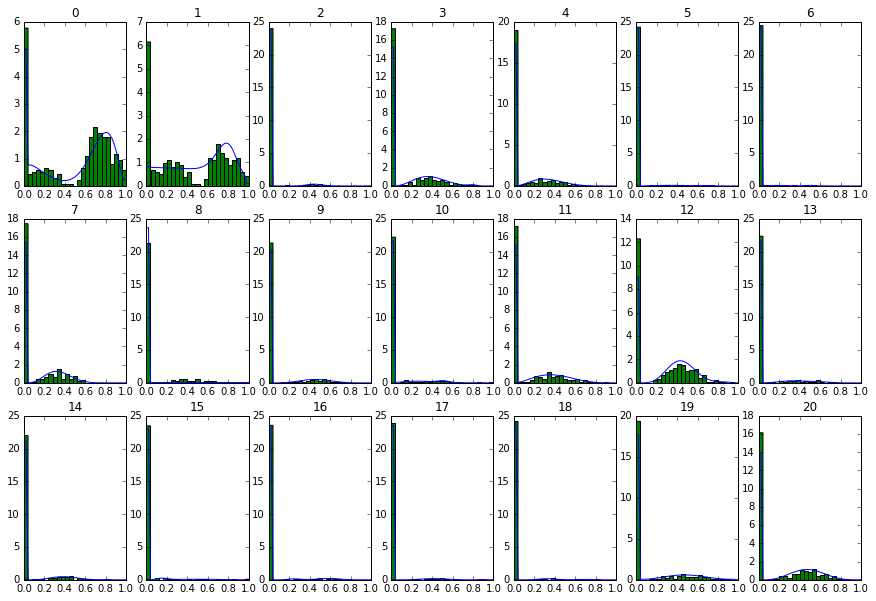

In [83]:
from scipy.stats import norm,beta,lognorm,gamma,chi2,uniform
fig,axes = plt.subplots(3,7,figsize=(15,10))
x = np.linspace(0,1,51)
bins = 25
sub = 2
for i,ax in enumerate(axes.flat):
    a1,b1,a2,b2,s,dip = [np.array(results[key])[sub][i] for key in ['a1','b1','a2','b2','state','dip']]
    if i==0 and 0:
        a1=2; b1=6; a2=12; b2=4; s = np.array([0.4,0.25,0.01,1,0.09])
        s /= s.sum()
    y = s[1]*beta.pdf(x,a1,b1) + \
        s[3]*beta.pdf(x,a2,b2) + \
        s[2]*uniform.pdf(x,0,1)
    y[:2] = s[0]*bins + s[2]*uniform.pdf(0,0,1)
    y[-2:] = s[4]*bins + s[2]*uniform.pdf(1,0,1)
    #y[(len(x)-1)/2] *= (1-dip)
    ax.plot(x,y)
    ax.hist(values[:,i,sub],range=(0,1),bins=bins,normed=True)
    ax.set_title('%d' % i)

In [293]:
from scipy.stats import norm,beta,lognorm,gamma,chi2,uniform
state,a1,a2,b1,b2 = [np.array(results[x]) for x in ['state','a1','a2','b1','b2']]
sub = 4
desc = 0
if 0:
    state[sub][desc] = np.array([0.4,0.25,0.01,1,0.09])
    state[sub][desc] /= state[sub][desc].sum()
    a1[sub][desc] = 2
    a2[sub][desc] = 6
    b1[sub][desc] = 12
    b2[sub][desc] = 4
logp_sum = 0
xs = []
logps = []
n_mol = values.shape[0]
for i in range(n_mol):
    if not values.mask[i,1,3]:
        x = values[i,1,3]
        if x==0:                    
            logp = np.log(state[sub][desc][0])# + 
                          #state[3][1][2]*uniform.pdf(0,0,1) + 
                          #state[3][1][1]*beta.pdf(0.00001,a1[3][1],b1[3][1]))
        elif x==1:
            logp = np.log(state[sub][desc][4])# + 
                          #state[3][1][2]*uniform.pdf(1,0,1) + 
                          #state[3][1][3]*beta.pdf(0.99999,a2[3][1],b2[3][1]))
        else:
            logp = np.log(state[sub][desc][1]*beta.pdf(x,a1[sub][desc],b1[sub][desc]) +
                          state[sub][desc][2]*uniform.pdf(x,0,1) +
                          state[sub][desc][3]*beta.pdf(x,a2[sub][desc],b2[sub][desc]))
        #print(x,logp)
        logp_sum += logp
        xs.append(x)
        logps.append(logp)
xs = np.array(xs)
logps = np.array(logps)
print(logp_sum)

-313.556391628


-138.28420087494993

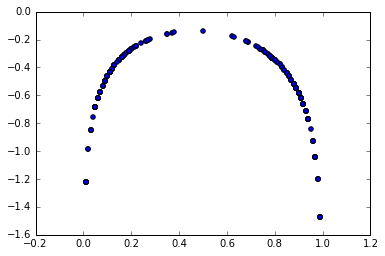

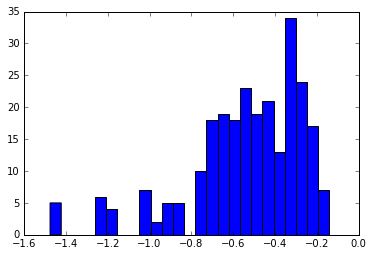

In [294]:
plt.scatter(xs[(xs!=0) & (xs!=1)],logps[(xs!=0) & (xs!=1)])
plt.figure()
plt.hist(logps[(xs!=0) & (xs!=1)],bins=25);
logps[(xs!=0) & (xs!=1)].sum()

In [5]:
CIDs = loading.get_CIDs('training')
values = np.zeros((49,len(CIDs),21,2),dtype='float')
mask = np.ones((49,len(CIDs),21,2),dtype='int')
for line in perceptual_obs_data:
    CID_index = CIDs.index(int(line[0]))
    subject = int(line[5])
    is_replicate = line[2]
    if line[4] == '1/1,000':
    #dilution_index = ['1/10','1/1,000','1/100,000'].index(line[4])
        for i,value in enumerate(line[6:]):
            if value != 'NaN':
                mask[subject-1,CID_index,i,int(is_replicate)] = 0
                if float(value) < 1:
                    value = 0.4
                elif float(value) > 99:
                    value = 99.6
                values[subject-1,CID_index,i,int(is_replicate)] = float(value) 